## Milestone 1:
For the first milestone, each team should complete the following steps for the offered grade:

- Define the software environment (e.g. requirements.txt, Dockerfile, etc.)
- Data acquisition: indicating the data source, and how you downloaded it (Python script or IPYNB)
- Data preparation. Final output: training, validation and test inputs and outputs. (Python script or IPYNB)
- Containerization : initial version of the Dockerfile to be used later

To complete milestone 1, create a GitHub repository for your group with the following in readme.md:

- team name,
- team members' names and Neptun codes,
- project description,
- functions of the files in the repository,
- related works (papers, GitHub repositories, blog posts, etc),
-and how to run it (building and running the container, running your solution within the container).

In this assignment, you have to submit the URL of the solution. One submission per group is asked and needed.

Imports

In [171]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torchvision.datasets import Flowers102, OxfordIIITPet
from PIL import Image

Reprodukálhatóság érdekében beállítunk egy seedet.

In [172]:
torch.manual_seed(42)

### Data acquisition and analysis
Torchvisionben is elérhető flowers102 és OxfordIIIPet dataset kerül letöltésre kódból, amiket transzformálunk, hogy egységesek legyenek.

In [173]:
flowers_dataset = Flowers102(root="./data", split="train", transform=None, download=True)
pets_dataset = OxfordIIITPet(root="./data", split="trainval", transform=None, download=True)
print(flowers_dataset)
print(pets_dataset)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./data


Nézzük meg, hogy a datasetek képeinek milyen az osztály szerinti eloszlása, illetve mekkorák a képek.


In [174]:
def plot_class_size_distribution(dataset, dataset_name):
    # Get the labels (class) for each image
    classes = [label for _, label in dataset]

    # Count the occurrences of each class
    class_counts = Counter(classes)

    # Get the class sizes (number of samples per class)
    class_sizes = list(class_counts.values())

    # Plot the histogram of class sizes
    plt.figure(figsize=(10, 6))
    sns.histplot(class_sizes, bins=30, kde=False)  # kde=False means no smooth curve, just bars
    plt.title(f"Class Size Distribution in {dataset_name} Dataset")
    plt.xlabel("Number of Samples per Class")
    plt.ylabel("Number of Classes")
    plt.show()

Flowers Dataset Class Distribution


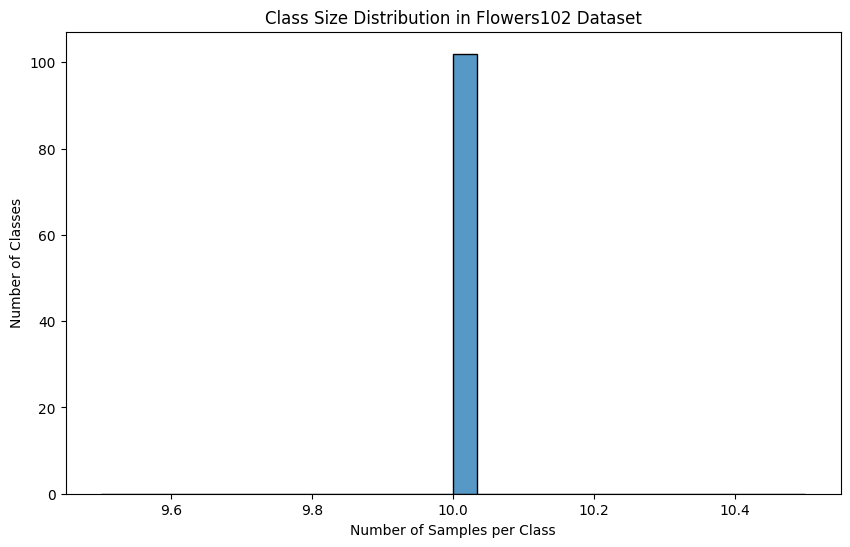


Pets Dataset Class Distribution


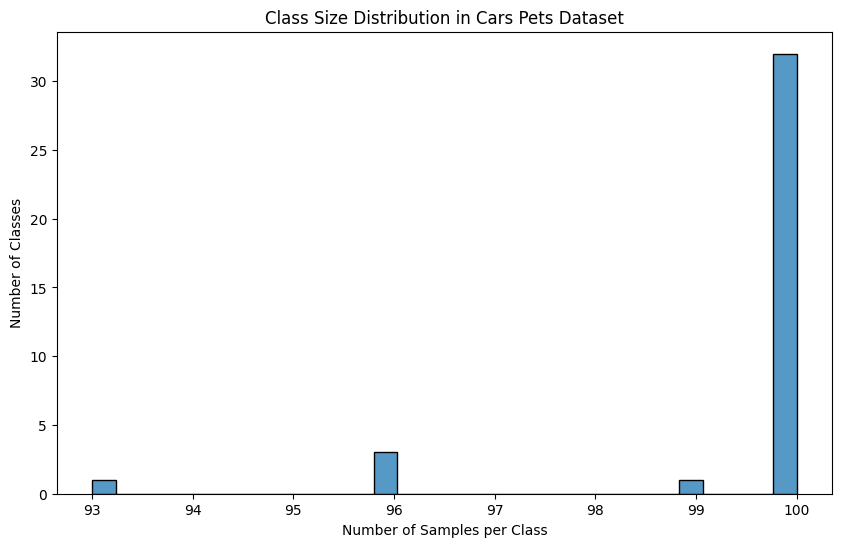

In [175]:
print("Flowers Dataset Class Distribution")
plot_class_size_distribution(flowers_dataset, "Flowers102")

print("\nPets Dataset Class Distribution")
plot_class_size_distribution(pets_dataset, "Cars Pets")

Az előző két diagram alapján azt lehet mondani, hogy a flowers102 datasetben nincsenek eltérések eloszlást nézve, hiszen minden osztályban 10 minta van, illetve a pets datasetben sincsenek nagy eltérések, így ebből a szempontból mindkét dataset megfelelő.


In [176]:
def categorize_resolution(width, height):
    if width < 256 and  height < 256:
        return 'Low (<256)'
    elif 256 <= width < 512 and 256 <= height < 512:
        return 'Medium (256-512)'
    elif 512 <= width < 1024 and 512 <= height < 1024:
        return 'High (512-1024)'
    else:
      return 'Very High (>=1024)'


def plot_image_size_distribution(dataset, dataset_name):
    resolution_counts = {
        'Low (<256)': 0,
        'Medium (256-512)': 0,
        'High (512-1024)': 0,
        'Very High (>=1024)': 0
    }
    for img, _ in dataset:
        if isinstance(img, str):
            img = Image.open(img)
        category = categorize_resolution(img.size[0], img.size[1])
        resolution_counts[category] += 1

    categories = list(resolution_counts.keys())
    counts = list(resolution_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.title(f'Image Size Distribution of {dataset_name} by Resolution Category')
    plt.xlabel('Resolution Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.show()


Flowers102 Dataset Image Size Analysis


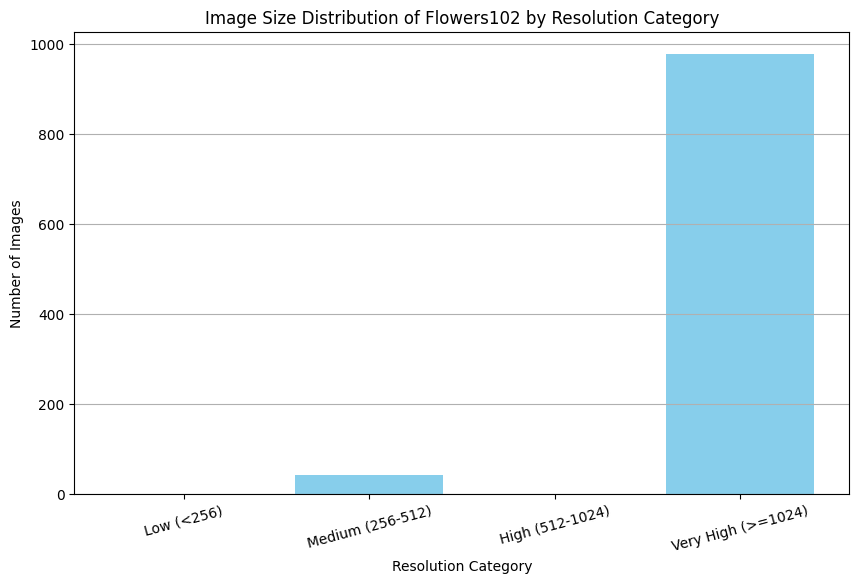


Oxford-IIIT Pet Dataset Image Size Analysis


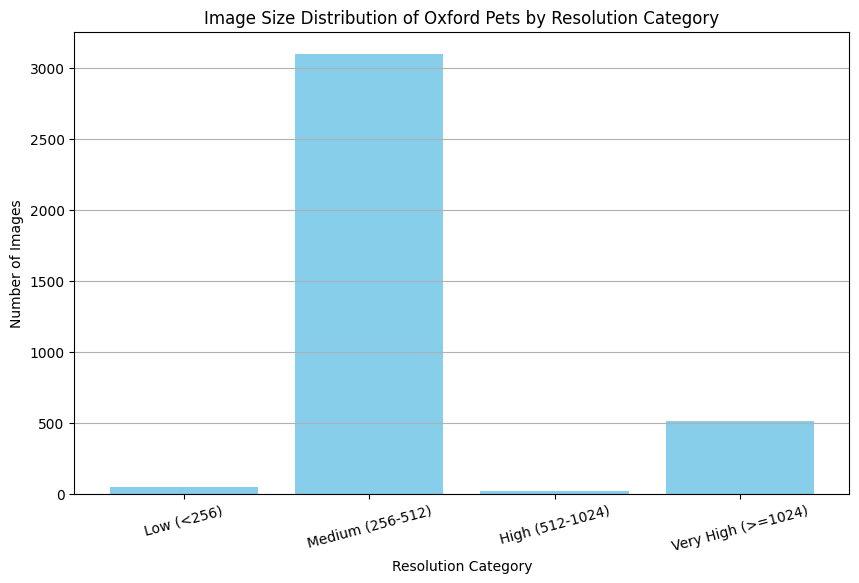

In [177]:
print("\nFlowers102 Dataset Image Size Analysis")
plot_image_size_distribution(flowers_dataset, "Flowers102")

print("\nOxford-IIIT Pet Dataset Image Size Analysis")
plot_image_size_distribution(pets_dataset, "Oxford Pets")

Mivel 256x256 méretre resizeolunk ezért ezek alapján sincs további teendő.


### Data preparation



Véletlenszerűen szétválasztjuk a datasetet a következő arányok szerint:
- Train: 70%,
- Validation: 15%,
- Test: 15%,

tekintettel arra, hogy a datasetjeink nagysága nem haladja meg a 10 000-et, illetve emiatt egy lépésben tölthetjük be az adatokat a memóriába.

In [178]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    return random_split(dataset, [train_size, val_size, test_size])

In [179]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
flowers_dataset = Flowers102(root="./data", split="train", transform=train_transform, download=True)
pets_dataset = OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=True)

In [180]:
flowers_train, flowers_val, flowers_test = split_dataset(flowers_dataset)
pets_train, pets_val, pets_test = split_dataset(pets_dataset)


In [181]:

flowers102_train_loader = DataLoader(flowers_train, batch_size=64, shuffle=True)
flowers102_val_loader = DataLoader(flowers_val, batch_size=64, shuffle=False)
flowers102_test_loader = DataLoader(flowers_test, batch_size=64, shuffle=False)

oxford_pets_train_loader = DataLoader(pets_train, batch_size=64, shuffle=True)
oxford_pets_val_loader = DataLoader(pets_val, batch_size=64, shuffle=False)
oxford_pets_test_loader = DataLoader(pets_test, batch_size=64, shuffle=False)

In [182]:
print(f"Flowers102 dataset: {len(flowers_train)} training, {len(flowers_val)} validation, {len(flowers_test)} test samples")
print(f"Oxford-IIIT Pets dataset: {len(pets_train)} training, {len(pets_val)} validation, {len(pets_test)} test samples")

Flowers102 dataset: 714 training, 153 validation, 153 test samples
Oxford-IIIT Pets dataset: 2576 training, 552 validation, 552 test samples



### Training the model

We using an Autoencoder model for the training


In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Model setup
model = Autoencoder()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [184]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load previously prepared datasets (Flowers102 and OxfordIIITPet)
flowers_dataloader = DataLoader(flowers_dataset, batch_size=64, shuffle=True)
pets_dataloader = DataLoader(pets_dataset, batch_size=64, shuffle=True)

In [185]:
def training_model(dataloader):
    model.train()
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        for images, _ in dataloader:
            # Move images to the appropriate device if needed (e.g., GPU)
            images = images

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)  # Reconstruction loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete.")

In [186]:
import torch
print(torch.cuda.is_available())  # Should return True if your GPU is set up correctly


True


In [187]:
training_model(flowers_dataloader)

Epoch [1/10], Loss: 0.2754
Epoch [2/10], Loss: 0.1149
Epoch [3/10], Loss: 0.0855
Epoch [4/10], Loss: 0.0627
Epoch [5/10], Loss: 0.0600
Epoch [6/10], Loss: 0.0397
Epoch [7/10], Loss: 0.0363
Epoch [8/10], Loss: 0.0289
Epoch [9/10], Loss: 0.0254
Epoch [10/10], Loss: 0.0203
Training complete.


In [188]:
#training_model(pets_dataloader)

In [189]:
import matplotlib.pyplot as plt

model.eval()

# Function to display original and reconstructed images
def display_reconstructions(model, dataloader, num_images=5):
    with torch.no_grad():
        images, _ = next(iter(dataloader))
        outputs = model(images)

        fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(images[i].permute(1, 2, 0) * 0.5 + 0.5)
            axes[0, i].axis('off')
            # Reconstructed images
            axes[1, i].imshow(outputs[i].permute(1, 2, 0) * 0.5 + 0.5)
            axes[1, i].axis('off')

        plt.show()

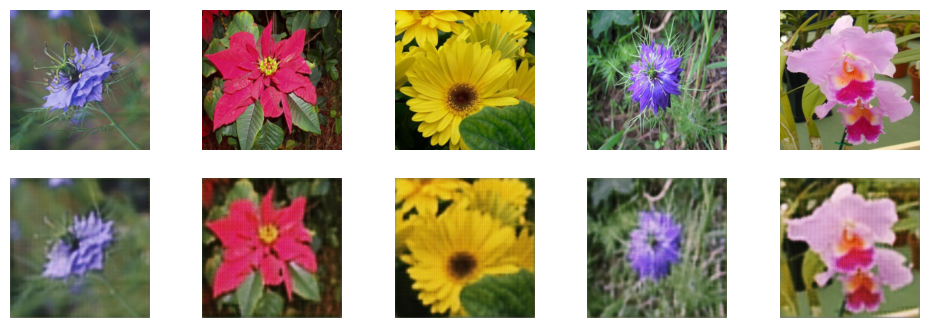

In [190]:

display_reconstructions(model, flowers_dataloader)

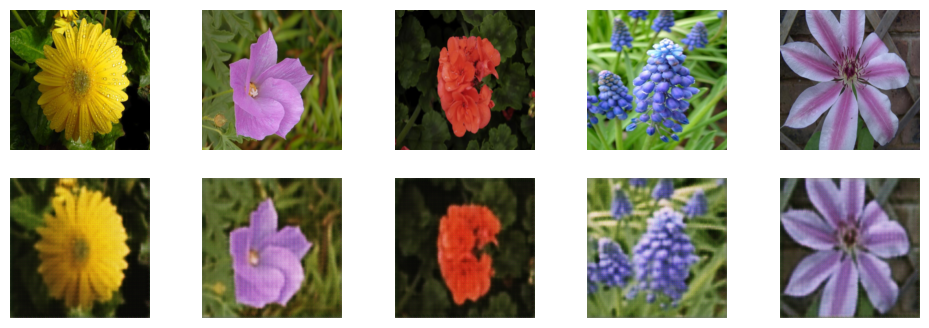

In [191]:
display_reconstructions(model, flowers_dataloader)

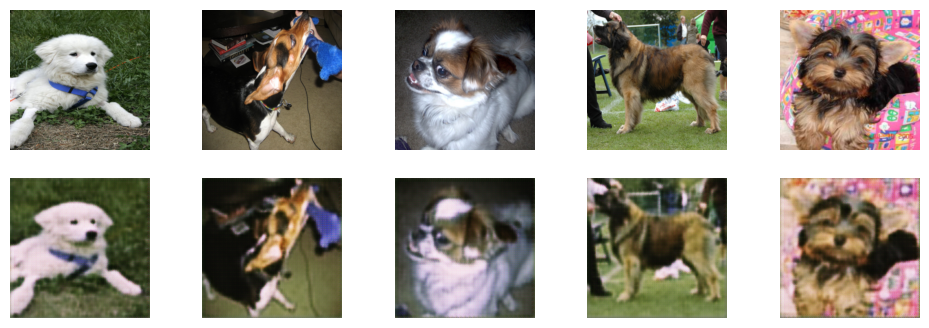

In [192]:
display_reconstructions(model, pets_dataloader)

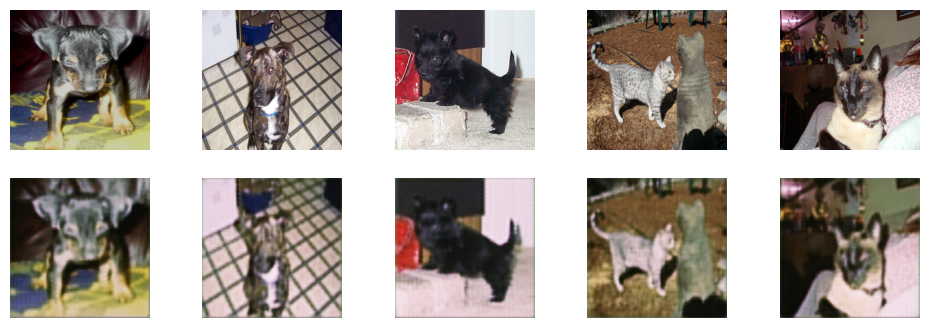

In [193]:
display_reconstructions(model, pets_dataloader)


### Defining Evaluation Criteria

For evaluating the quality of generated images from the diffusion models, we will use the following metrics:

1. **Fréchet Inception Distance (FID)**: Measures the similarity between generated images and real images by comparing the mean and covariance of features extracted from the Inception network. Lower values are better, indicating closer similarity to real data.

2. **Inception Score (IS)**: Measures the quality of generated images based on their diversity and how "confident" the Inception network is in classifying them into distinct categories. Higher scores indicate better diversity and quality.

We will implement and calculate these metrics after training the diffusion models.


In [194]:

from torchmetrics.image.fid import FrechetInceptionDistance as fid_score
from torchmetrics.image.inception import InceptionScore

# Function to calculate FID
def calculate_fid(real_images_path, generated_images_path):
    fid_value = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size=64, device="cuda")
    return fid_value

# Function to calculate Inception Score
def calculate_inception_score(images_loader):
    inception_score = InceptionScore()
    for images, _ in images_loader:
        inception_score.update(images)
    score = inception_score.compute()
    return score



### Baseline (Reference) Model

As a baseline, we will generate random noise images and evaluate them using the same metrics (FID and IS). This provides a simple reference point to understand how much the diffusion models improve over random noise.

The baseline can be defined by generating random noise tensors of the same dimensions as the images in the dataset.


In [195]:

import torch

# Generate baseline random noise images
def generate_baseline_noise_images(num_images, image_shape):
    random_images = torch.randn(num_images, *image_shape) #.to(device)
    return random_images

# Example: Generate 64 random noise images of shape (3, 256, 256)
baseline_images = generate_baseline_noise_images(64, (3, 256, 256))
